# Tutorial: Introduction to Unsupervised Learning with a Focus on PCA

Tutorial to the class [Introduction to Unsupervised Learning with a Focus on PCA](7_unsupervised_learning_pca.ipynb).

<div class="alert alert-block alert-info">
    <b>Tutorial Objectives</b>
    
- Apply Principal Component Analysis (PCA) to climate data to analyze patterns of variability
- (Combine PCA reduction/$k$-means clustering to Ordinary Least Squares (OLS) to predict climate variables)
- (Use cross-validation to regularize the OLS with the number of retained Empirical Orthogonal Functions (EOFs) or clusters).
</div>

## Dataset presentation

- Input:
  - [Geopotential height](https://en.wikipedia.org/wiki/Geopotential_height) at 500hPa
    - Domain: North Atlantic
    - Spatial resolution: $0.5° \times 0.625°$
    - Time resolution: monthly
    - Period: 1980-2018
    - Units: m
    - Source: [MERRA-2 reanalysis](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/)
- Target:
  - Onshore wind capacity factors
    - Domain: Metropolitan France
    - Spatial resolution: regional mean
    - Time resolution: monthly
    - Period: 2014-2018
    - Units:
    - Source: [RTE](https://opendata.reseaux-energies.fr/)

In [1]:
# Import modules
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Data directory
DATA_DIR = Path('data')

# Filename to geopotential height at 500hPa from MERRA-2 reanalysis
filename = 'merra2_analyze_height_500_month_19800101-20190101.nc'

> ***Question***
> - Read the geopotential height data using `xarray.load_dataset` and print it.

In [2]:
# Import xarray
import xarray as xr

# Read dataset with xarray
filepath = Path(DATA_DIR, filename)
ds = xr.load_dataset(filepath)

# Select geopotential height variable
da = ds['height_500']
da

<xarray.DataArray 'height_500' (time: 468, lat: 45, lon: 72)>
array([[[9136.35   , 9137.496  , 9138.719  , ..., 9154.949  ,
         9152.873  , 9151.166  ],
        [9127.393  , 9128.267  , 9129.559  , ..., 9145.457  ,
         9143.62   , 9142.331  ],
        [9107.896  , 9109.125  , 9110.381  , ..., 9125.638  ,
         9124.227  , 9123.147  ],
        ...,
        [ 736.0465 ,  735.869  ,  735.7365 , ...,  733.2463 ,
          733.51874,  733.82855],
        [ 457.5072 ,  457.41122,  457.32016, ...,  455.69968,
          455.8278 ,  455.96658],
        [ 176.2095 ,  176.19121,  176.17296, ...,  175.86177,
          175.88231,  175.9034 ]],

       [[9143.847  , 9144.416  , 9145.192  , ..., 9158.306  ,
         9157.289  , 9157.579  ],
        [9135.326  , 9135.735  , 9136.585  , ..., 9148.722  ,
         9147.875  , 9147.997  ],
        [9116.052  , 9116.739  , 9117.459  , ..., 9129.615  ,
         9129.149  , 9128.99   ],
...
        [ 736.07556,  736.197  ,  736.33966, ...,  732.5051 ,
          732.16174,  731.8547 ],
        [ 455.8819 ,  455.949  ,  456.02087, ...,  454.44766,
          454.34607,  454.2581 ],
        [ 175.29803,  175.30824,  175.3183 , ...,  175.10855,
          175.0974 ,  175.08652]],

       [[9154.29   , 9154.452  , 9154.705  , ..., 9171.743  ,
         9171.175  , 9170.811  ],
        [9146.553  , 9146.631  , 9147.146  , ..., 9162.506  ,
         9161.903  , 9161.3545 ],
        [9128.671  , 9128.673  , 9128.721  , ..., 9143.024  ,
         9142.27   , 9141.458  ],
        ...,
        [ 717.3173 ,  717.2497 ,  717.17456, ...,  718.9412 ,
          718.9246 ,  718.92334],
        [ 443.37286,  443.34793,  443.31857, ...,  444.38455,
          444.39832,  444.41364],
        [ 170.46103,  170.45703,  170.45296, ...,  170.61038,
          170.61359,  170.6164 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2018-12-01
  * lat      (lat) float64 0.75 2.75 4.75 6.75 8.75 ... 82.75 84.75 86.75 88.75
  * lon      (lon) float64 -99.06 -96.56 -94.06 -91.56 ... 73.44 75.94 78.44
Attributes:
    long_name:       height_at_500_hPa
    units:           m
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]
    origname:        H500
    fullnamepath:    /H500
    height:          2.0

> ***Question***
> - Compute the mean and the variance of the geopotential height with the `mean` and `var` methods.
> - Plot the mean with the `plot` method.
> - Do a filled-contour plot of the variance with the `plot.contourf` method.

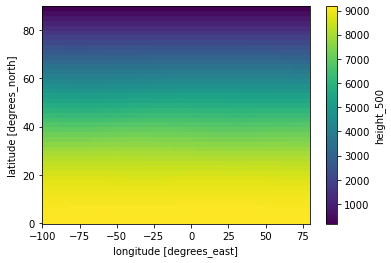

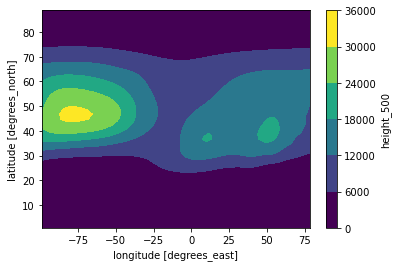

In [3]:
# Compute the mean
da_mean = da.mean('time')

# Plot mean per grid point with pcolormesh
plt.figure()
da_mean.plot()

# Compute deviations from the mean
da_dev = da - da_mean

# Compute the variance
da_var = da_dev.var('time')

# Plot variance per grid point with contourf
plt.figure()
da_var.plot.contourf()

> ***Question***
> - Plot the variance of the geopotential height on the map. To do so, import `cartopy.crs` and use it to define the `projection` argument of `plt.subplot`, and use the `coastlines` and the `gridlines` method of the axes.

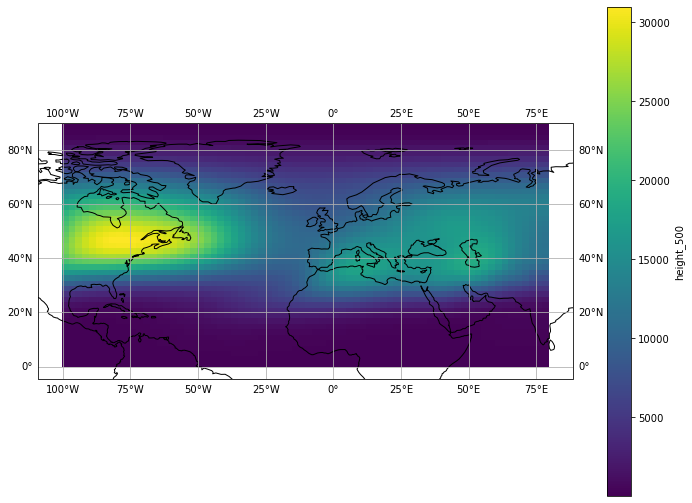

In [4]:
# Import Cartopy's coordinate reference system
import cartopy.crs as ccrs

# Plot variance with costlines and gridlines
fig = plt.figure(figsize=[12, 9])
ax = plt.subplot(projection=ccrs.PlateCarree())
p = da_var.plot(ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)

> ***Question***
> - Scale the geopotential-height deviations to account for variations in the area represented by each grid point.
> - Plot the variance of the scaled geopotential height.

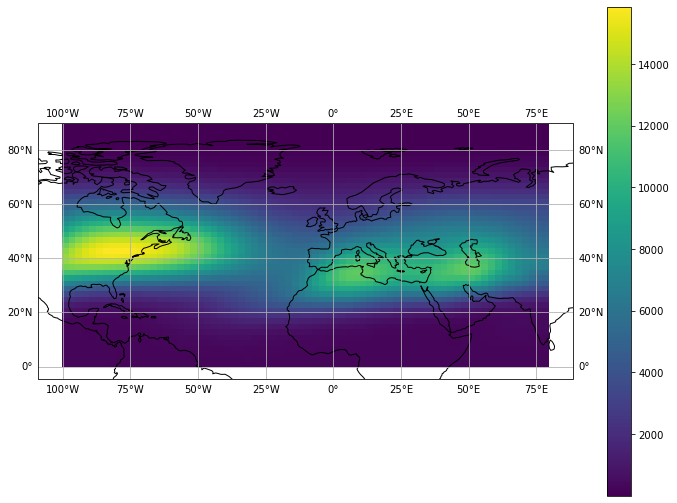

In [5]:
# Get grid-point area coefficients
coef = np.cos(np.deg2rad(da['lat']))

# Scale height by coefficient
da_scaled = da_dev * coef

# Plot scaled variance with costlines and gridlines
fig = plt.figure(figsize=[12, 9])
ax = plt.subplot(projection=ccrs.PlateCarree())
p = da_scaled.var('time').plot(ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)

> ***Question***
> - Estimate the covariance matrix of the scaled geopotential height using the `stack` method of data arrays.

In [6]:
# Get input matrix
da_scaled_2d = da_scaled.stack(latlon=['lat', 'lon'])
X = da_scaled_2d.values

# Estimate covariance matrix
Sigma = np.cov(X.T)

> ***Question***
> - Compute EOFs and corresponding variances using `np.linalg.eigh`.

In [7]:
# Compute eigenvalues and eigenvectors
lam, V = np.linalg.eigh(Sigma)

> ***Question***
> - Sort the EOFs and corresponding variances by decreasing variances.
> - Plot the fraction of variance "explained" by the leading 20 EOFs.
> - Interpret your results.

([<matplotlib.axis.XTick at 0x7fb5ac1c1730>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

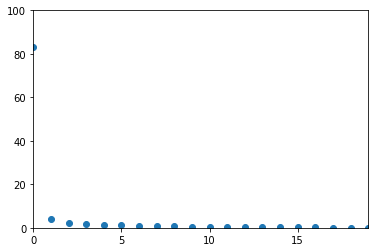

In [8]:
# Sort eigenvalues and eigenvectors by decreasing eigenvalues
isort = np.argsort(-lam)
lam = lam[isort]
V = V[:, isort]

# Convert eigenvalues to explained variance percentage
expvar = lam / lam.sum() * 100

# Plot first 20 explained variances
n_eig = 20
xlim = [0., n_eig - 1]
x = np.arange(len(expvar[:n_eig]))
plt.figure()
plt.scatter(np.arange(len(expvar[:n_eig])), expvar[:n_eig])
plt.xlim(xlim)
plt.ylim(0., 100.)
plt.xticks(range(0, n_eig, 5))

Answer: 

> ***Question***
> - Plot the leading EOF on a map.
> - To what physical phenomenon could this pattern be associated to?

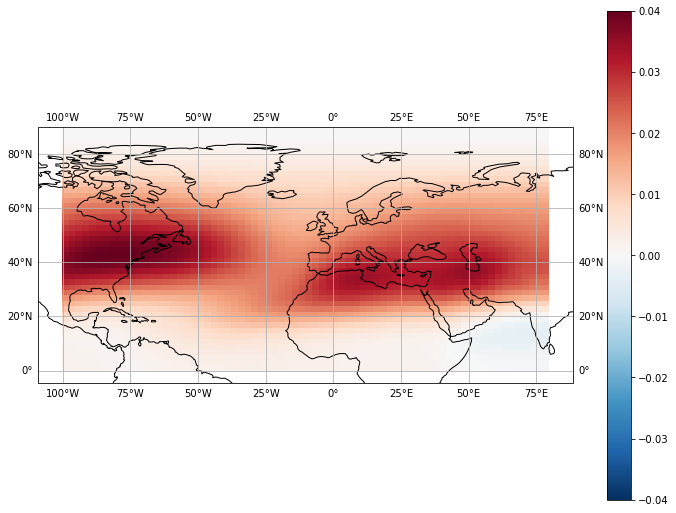

In [9]:
# Convert first eigenvector to data array
da_scaled_2d_v0 = xr.DataArray(V[:, 0], coords=[
    da_scaled_2d.coords['latlon']])

# Unstack latitudes and longitudes
da_v0 = da_scaled_2d_v0.unstack('latlon')

# Plot first eigenvector
fig = plt.figure(figsize=[12, 9])
ax = plt.subplot(projection=ccrs.PlateCarree())
p = da_v0.plot(ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)

Answer: 

> ***Question***
> - Compute the principal component associated with the leading EOF.
> - Compare its variance to the corresponding eigenvalue and explain your result.
> - Plot this principal component.
> - Confirm or reconsider you previous answer on the physical phenomenon that could be associated to the leading EOF.

9263883.680261413 9283720.690283371


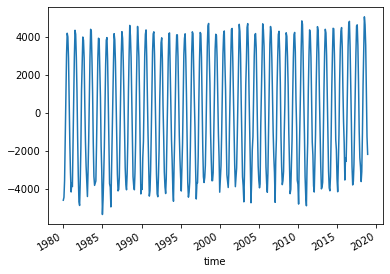

In [10]:
# Compute first principal component
a0 = X @ V[:, 0]

# Compare variance of first principal component to corresponding eigenvalue
print(a0.var(), lam[0])

# Plot first principal component
da_a0 = xr.DataArray(a0, coords=[da_scaled_2d.coords['time']])

da_a0.plot()

Answer: 

Answer: 

> ***Question (optional)***
> - Use the `scipy.signal.welch` to estimate the Power Spectral Density (PSD) of the leading principal component and plot it.
> - Confirm or reconsider you previous answer on the physical phenomenon that could be associated to the leading EOF.

Text(0.5, 1.0, 'Period of PSD maximum: 12.2 months')

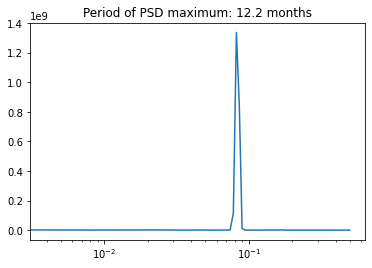

In [11]:
# Import signal module from Scipy
from scipy import signal

# Get PSD from Welch estimator
freqs, psd = signal.welch(a0)

# Plot and give period at maximum in title
plt.semilogx(freqs, psd)
plt.title('Period of PSD maximum: {:.1f} months'.format(1. / freqs[psd.argmax()]))

> ***Question***
> - Compute the seasonal cycle of the geopotential height (averages over all years of the same month of the year for each month) with the `groupby` of data arrays.
> - Plot all 12 months. You can use the `col` option of the `plot` method of data arrays.
> - Also plot the variance of the seasonal cycle on a map.
> - Confirm or reconsider you previous answer on the physical phenomenon that could be associated to the leading EOF.

/home/atantet/.conda/envs/default/lib/python3.9/site-packages/xarray/plot/facetgrid.py:390: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


<Figure size 432x288 with 0 Axes>

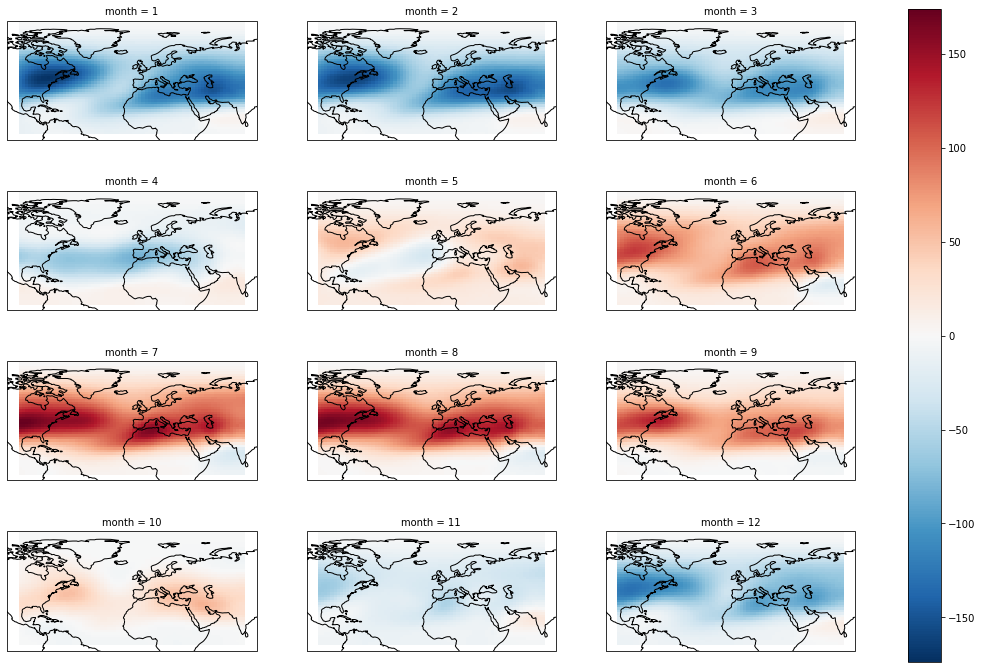

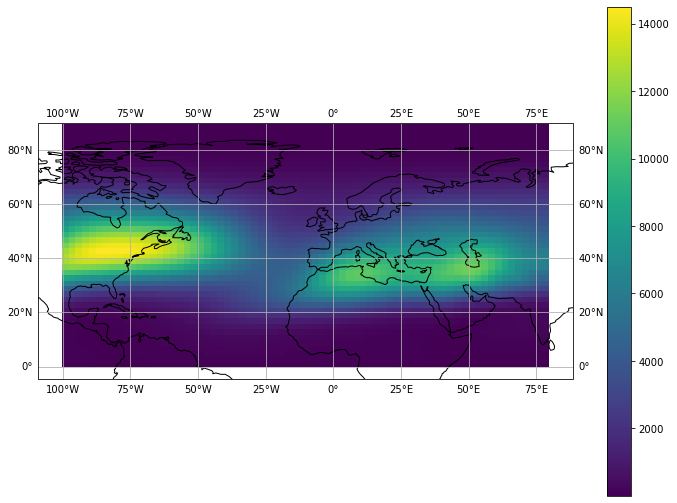

In [12]:
# Compute monthly seasonal cycle
gps = da_scaled.groupby('time.month')

# Get seasonal cycle
da_seasonal = gps.mean()

# Plot each month of seasonal cycle
fig = plt.figure()
col_wrap = 3
g = da_seasonal.plot(x='lon', y='lat', col='month', col_wrap=col_wrap,
                     subplot_kws=dict(projection=ccrs.PlateCarree()),
                     aspect=2)
for ax in g.axes.flat:
    ax.coastlines()

# Plot variance of seasonal cycle
fig = plt.figure(figsize=[12, 9])
ax = plt.subplot(projection=ccrs.PlateCarree())
p = da_seasonal.var('month').plot(ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)

Answer: 

> ***Question***
> - Compute seasonal anomalies (deviations from the seasonal cycle) of the geopotential height with `groupby`.
> - Plot the variance of the seasonal anomalies on a map.
> - How does it compare to the variance of the data with the seasonal cycle?

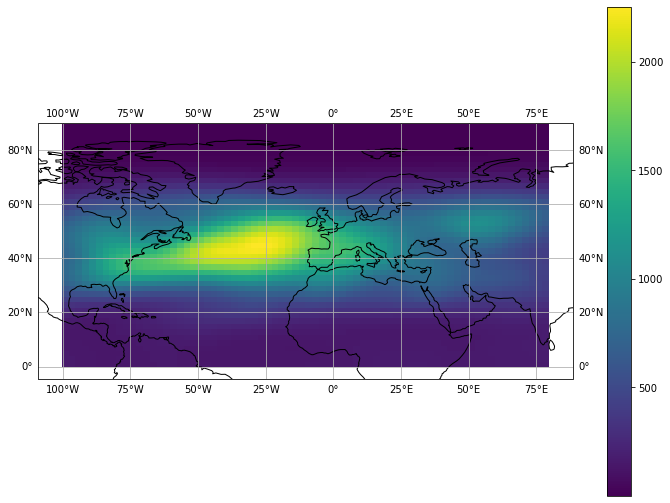

In [13]:
# Get seasonal anomalies
da_anom = da_scaled.groupby('time.month') - da_seasonal

# Plot variance of the seasonal anomalies on a map
fig = plt.figure(figsize=[12, 9])
ax = plt.subplot(projection=ccrs.PlateCarree())
p = da_anom.var('time').plot(ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)

Answer:

> ***Question***
> - Estimate the covariance matrix of the seasonal anomalies.
> - Compute the EOFs and corresponding variances.
> - Plot the explained variances associated with the EOFs together with the cumulative sum of the explained variances.
> - What is the minimum number of EOFs that one needs to keep to explain at least 90% of the variance.

In [14]:
# Get input matrix for seasonal anomalies
da_anom_2d = da_anom.stack(latlon=['lat', 'lon'])
X_anom = da_anom_2d.values

# Estimate covariance matrix
Sigma_anom = np.cov(X_anom.T)

In [15]:
# Compute eigenvalues and eigenvectors
lam_anom, V_anom = np.linalg.eigh(Sigma_anom)

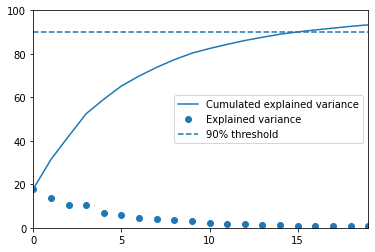

In [16]:
# Sort eigenvalues and eigenvectors by decreasing eigenvalues
isort = np.argsort(-lam_anom)
lam_anom = lam_anom[isort]
V_anom = V_anom[:, isort]

# Convert eigenvalues to explained variance percentage
expvar_anom = lam_anom / lam_anom.sum() * 100
cumexpvar_anom = expvar_anom.cumsum()

# Plot first 20 explained variances
n_eig = 20
xlim = [0., n_eig - 1]
x = np.arange(len(expvar_anom[:n_eig]))
plt.figure()
plt.scatter(x, expvar_anom[:n_eig], label='Explained variance')
plt.plot(x, cumexpvar_anom[:n_eig], label='Cumulated explained variance')
plt.hlines(90., *xlim, linestyle='--', label='90% threshold')
plt.xlim(xlim)
plt.ylim(0., 100.)
plt.xticks(range(0, n_eig, 5))
plt.legend()

Answer:

> ***Question***
> - Plot the leading 4 EOFs and principal components.
> - Can you associate these patterns to known climate phenomena?

/home/atantet/.conda/envs/default/lib/python3.9/site-packages/xarray/plot/facetgrid.py:390: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


<Figure size 432x288 with 0 Axes>

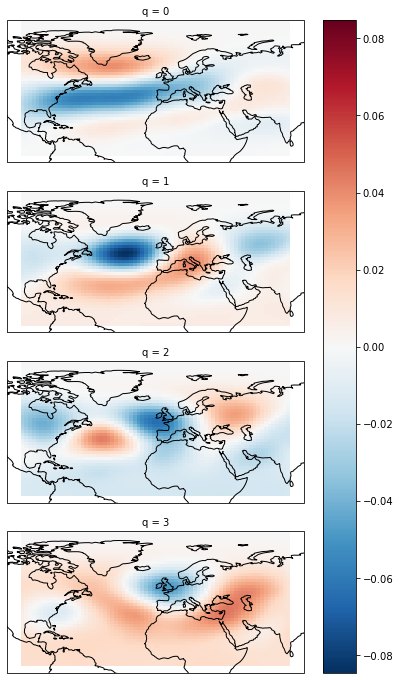

<Figure size 432x288 with 0 Axes>

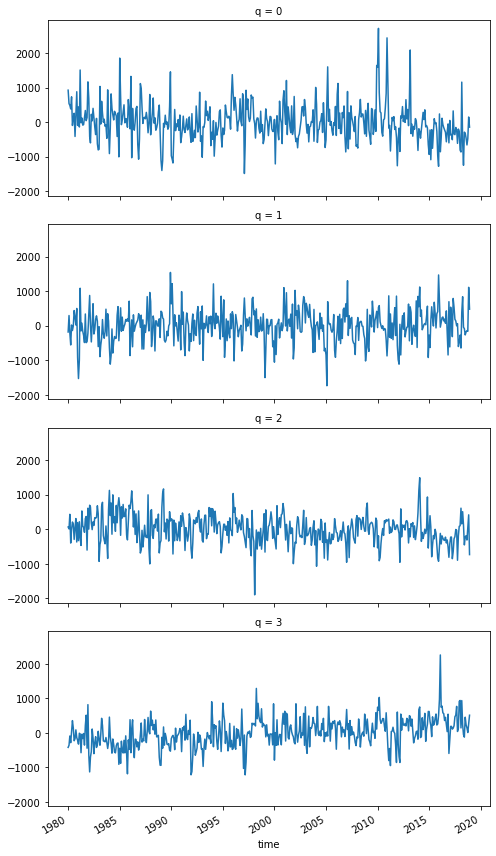

In [17]:
# Plot leading EOFs and principal components
n_eof = 4
coord_eof = 'q', range(n_eof)
da_v_anom = xr.DataArray(V_anom[:, :n_eof], coords=[
    da_anom_2d.coords['latlon'], coord_eof]).unstack('latlon')

plt.figure()
g = da_v_anom.plot(x='lon', y='lat', col='q', col_wrap=1, aspect=2,
                   subplot_kws=dict(projection=ccrs.PlateCarree()))
for ax in g.axes.flat:
    ax.coastlines()
    
# Compute the leading principal components
A_anom = X_anom @ V_anom[:, :n_eof]

# Plot the leading principal component
plt.figure()
da_a_anom = xr.DataArray(A_anom, coords=[
    da_scaled_2d.coords['time'], coord_eof])
da_a_anom.plot.line(x='time', col='q', col_wrap=1, aspect=2)

Answer: 

> ***Question***
> - Reconstruct the inputs from the leading 4 EOFs only.
> - Compare the original time series at a few arbitrary locations to the corresponding reconstructed time series.
> - Plot the variance of the reconstruction on a map.
> - Same question but keeping more EOFs
> - Interpret your results in terms of filtering.

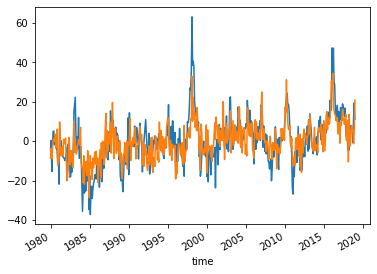

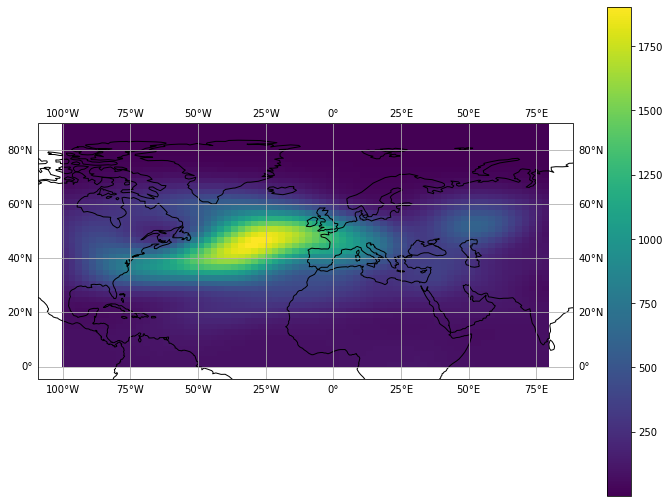

In [18]:
# Reconstruct the data from first 4 principal components
X_rec = A_anom @ V_anom[:, :n_eof].T

# Compare original time series and reconstruction at arbitrary grid points
ilatlon = 0
ts_anom = xr.DataArray(X_anom[:, ilatlon], coords=[da.coords['time']])
ts_rec = xr.DataArray(X_rec[:, ilatlon], coords=[da.coords['time']])
fig, ax = plt.subplots()
ts_anom.plot(ax=ax)
ts_rec.plot(ax=ax)

# Convert reconstruction to data array
da_rec_2d = xr.DataArray(X_rec, coords=[
    da.coords['time'], da_scaled_2d.coords['latlon']])

# Unstack latitudes and longitudes
da_rec = da_rec_2d.unstack('latlon')

# Plot variance of reconstruction on a map
fig = plt.figure(figsize=[12, 9])
ax = plt.subplot(projection=ccrs.PlateCarree())
p = da_rec.var('time').plot(ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)

Answer: 

> ***Question (optional)***
> - Design a linear model that best predicts present (not future) wind capacity factors in `data/reseaux_energies_capacityfactor_wind-onshore.csv` using geopotential-height principal components as inputs. To do, use cross-validation to regularize based on the number of leading principal components retained.

> ***Question (optional)***
> - Use $k$-means clustering with `sklearn.cluster.KMeans` to detect "atmospheric regimes" from the geopotential-height data and compare the result to the EOFs obtained above.
> - Design a linear model as above but based on clusters rather than EOFs.

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>